# Key Word extraction (Kaggle Facebook Dataset)




### Problem Definition:
The provided data set consist of user post on specific issues. When user creates a new post, the system automatically assign a relevant tag to the post. Given a training data set with id, Title, Body and Tag as fields, the task is to predict the most relevant tag to a test Data set (unseen data) having just id, Title and Body as fields

### Solution Approach
The problem essentially falls into a Multi-label category where each post could have multiple tags. I will be Exploring 2 major approach in my solution, namely:
1. Problem Transformation
2. Adapted Algorithm

#### Problem Transformation
This approach involves transforming our multi-label problem into multiple single-label problem such that we can use any Binary classification model as our base clasifier and then aggregate our results. I would be exploring two methods in this approach
namely Binary Relevance and Label Powerset
#####      1. Binary Relevance
Here, we are treating each label as a separate single-class classification problem.Take for example the data set (X:Y1,Y2,Y3,Y4) where X is the independent feature and Y’s are the target variable. What is done here is to break the problem set to (X,Y1), (X,Y2), (X,Y3) and (X,Y4), fit a model on each of the single-label problem, carry-out prediction and then aggregate result.
#####      2. Label Powerset
Here, the problem is transformed into a multi-class problem with one multi-class classifier trained on all unique label combinations found in the training data. In the example below, we find that x1 and x4 have the same label in our newly created label i.e. y*, similarly, x3 and x6 have the same set of labels. In summary, label powerset transforms the problem into a single multi-class problem such that we can apply any Multi-class Classification model.

     X   y1   y2   y3   y4      y* 
    X1   0    1    1    0       1  
    X2   1    0    0    0       2  
    X3   0    1    0    0       3  
    X4   0    1    1    0       1  
    X5   1    1    1    1       4  
    x6   0    1    0    0       3  


#### Adapted Algorithm
Adapted algorithm, as the name suggests, adapt an algorithm to directly perform multi-label classification, rather than transforming the problem into different subsets of problems. An example is the multi-label version of kNN represented by MLkNN in sickit Learn.

#### NB
Note that all the approaches and methods highlighted above are readily implemented and also well document in sickit-learn. Hence, I will be using sickit-learn package for this homework rather than re-invent the wheel which saves a lot of time.

#### Metrics
F1 score will be used to measure performance in this problem. F1 score is interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The formula for F1 score (also implemented in Sickit-learn) is: F1 = 2 * (precision * recall) / (precision + recall)

In our multi-class/multi-label case, this will be the weighted average of the F1 score of each class.

In [1]:
# Connect to Server and load data
from pymongo import MongoClient
client = MongoClient('compute-0-11', 27017)

db = client.FacebookChallenge_akar1
collection = db.fb_hw
collection_test = db.fb_hw_test
contents = collection.find().limit(10000)
contents_test = collection_test.find().limit(10000)

In [2]:
# Create SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark import SparkConf, SparkContext

spark = SparkSession.builder \
        .appName("Facebook_noi") \
        .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
# Load data into pyspark Dataframe
from bson import json_util, ObjectId
import json

rddSan = json.loads(json_util.dumps(contents))
rdd = sc.parallelize(rddSan)
schema = StructType([StructField("Body", StringType(), True), 
                     StructField("Id", IntegerType(), True), 
                     StructField("Tags", StringType(), True),
                     StructField("Title", StringType(), True),
                     StructField("_id", StringType(), True)])

train = sqlContext.createDataFrame(rdd, schema=schema)

In [4]:
#Creating DataFrame for Test data
rddSan_test = json.loads(json_util.dumps(contents_test))
rdd_test = sc.parallelize(rddSan_test)
schema_test = StructType([StructField("Body", StringType(), True), 
                     StructField("Id", IntegerType(), True), 
                     StructField("Title", StringType(), True),
                     StructField("_id", StringType(), True)])

test = sqlContext.createDataFrame(rdd_test, schema=schema_test)

In [5]:
# Drop the system generated ID column and display the resulting dataframe
train_df = train.drop("_id")
train_df = train_df.toPandas()
train_df.head(3)

,Body,Id,Tags,Title
0,<p>I'd like to check if an uploaded file is an...,1,php image-processing file-upload upload mime-t...,How to check if an uploaded file is an image w...
1,"<p>In my favorite editor (vim), I regularly us...",2,firefox,How can I prevent firefox from closing when I ...
2,"<p>This is probably very simple, but I simply ...",4,c# url encoding,How do I replace special characters in a URL?


In [6]:
# Create Functions to help clean and pre-process the text data

from collections import Counter
from pyspark.ml.feature import StopWordsRemover
import re
import pandas as pd
from collections import Counter
import string
import nltk
from nltk.corpus import wordnet

# Function 1: Text Preprocessing
def makeWordList(ls):
    ls = re.sub(r'http\S+', ' ', ls)
    ls = re.sub(r'<.*?>', ' ', ls)
    ls = re.sub(r'\S*\d\S*',' ',ls) 
    for c in string.punctuation:
        if c not in ['#','_','-','+', '.']:
            ls = ls.replace(c, "") 
        
    text = ls.lower().split()                        
    li = []
    stopW = ['im', 'id', 'hi','ive', 'hello','eg', '+', '.','e.g','-']
    lemma = nltk.wordnet.WordNetLemmatizer()
    for token in text:
        if token not in stopW and len(token) < 25:
            li.append(lemma.lemmatize(token.strip(".")))
    return li


# Function 2: To remove duplicate tokens 
def remDuplicate(li):      
    all_words = list(set(li))
    return all_words

In [7]:
# Prepare the Training Data

# The List of words in the training data will form my feature
# Due to infrastructure limitation, I would only be working with the top 1000 words by frequency of occurrence
# Also because I would be working with only 1000 words, I am deliberatly leaving out the body of the post in the consideration
# of the top 1000. This is mainly because I noticed the Titles and the Tags have better predicting power 
# and both are already over 12,000

train_df['Title'] = train_df['Title'].apply(makeWordList)
train_df['Tags'] = train_df.Tags.str.split('\s+') 
train_df['combined'] = train_df['Title'] + train_df['Tags']  
train_df['combined'] = train_df['combined'].apply(remDuplicate)
train_df.head(3)

,Body,Id,Tags,Title,combined
0,<p>I'd like to check if an uploaded file is an...,1,"[php, image-processing, file-upload, upload, m...","[how, to, check, if, an, uploaded, file, is, a...","[uploaded, mime-types, to, file-upload, type, ..."
1,"<p>In my favorite editor (vim), I regularly us...",2,[firefox],"[how, can, i, prevent, firefox, from, closing,...","[prevent, from, i, when, how, can, press, fire..."
2,"<p>This is probably very simple, but I simply ...",4,"[c#, url, encoding]","[how, do, i, replace, special, character, in, ...","[a, do, c#, encoding, i, character, replace, h..."


In [8]:
# Remove Stopwords

from pyspark.ml.feature import StopWordsRemover

train_df2 = sqlContext.createDataFrame(train_df)
remover = StopWordsRemover(inputCol="combined", outputCol="Filtered")
train_df3= remover.transform(train_df2)
train_df3.show(5)

+--------------------+---+--------------------+--------------------+--------------------+--------------------+
|                Body| Id|                Tags|               Title|            combined|            Filtered|
+--------------------+---+--------------------+--------------------+--------------------+--------------------+
|<p>I'd like to ch...|  1|[php, image-proce...|[how, to, check, ...|[uploaded, mime-t...|[uploaded, mime-t...|
|<p>In my favorite...|  2|           [firefox]|[how, can, i, pre...|[prevent, from, i...|[prevent, press, ...|
|<p>This is probab...|  4| [c#, url, encoding]|[how, do, i, repl...|[a, do, c#, encod...|[c#, encoding, ch...|
|<pre><code>functi...|  5|[php, api, file-g...|[how, to, modify,...|[file-get-content...|[file-get-content...|
|<p>I am using a m...|  6|[proxy, active-di...|[setting, proxy, ...|[active-directory...|[active-directory...|
+--------------------+---+--------------------+--------------------+--------------------+--------------------+
o

In [9]:
# Generate list of words (Features) and sort by frequency of occurrence

from collections import Counter, OrderedDict

train_df4 = train_df3.toPandas()
wordList = train_df4['Filtered'].tolist()
all_words = [j for i in wordList for j in i] 
all_words.sort(key=Counter(all_words).get, reverse=True)
all_words=OrderedDict.fromkeys(all_words).keys()

In [12]:
#Convert the words to Feature Matrix considering only the top 1000
import numpy as np

df5 = pd.DataFrame(0, index=np.arange(len(wordList)), columns=all_words[:1000]) 
indx = 0
for indx in list(range(len(wordList))):
    for col in df5.columns:
        if col in wordList[indx]:
            df5.iloc[indx,df5.columns.get_loc(col)] = 1                          
df5.head(5)

,c#,java,php,using,javascript,android,jquery,file,asp.net,sql,...,file-upload,contact,generating,parameters,equal,sent,android-ndk,align,username,exists
0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Generate the List of Labels from the Tags. 
# Again, I will be considering only the top 200 Tags as the Labels due to infrastructure limitation

from collections import Counter, OrderedDict

TagList = train_df4['Tags'].tolist()
all_Tags = [j for i in TagList for j in i] 
all_Tags.sort(key=Counter(all_Tags).get, reverse=True)
all_Tags=OrderedDict.fromkeys(all_Tags).keys()

df6_Label = pd.DataFrame(0, index=np.arange(len(TagList)), columns=all_Tags[:200])  # Working with 200 Columns (Tags)  
indx = 0
for indx in list(range(len(TagList))):
    for col in df6_Label.columns:
        if col in TagList[indx]:
            df6_Label.iloc[indx,df6_Label.columns.get_loc(col)] = 1                          
df6_Label.head(10)

,c#,java,php,javascript,android,jquery,c++,asp.net,.net,python,...,visual-studio-2008,linq-to-sql,curl,debugging,generics,database-design,node.js,gwt,fonts,templates
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Approach 1: Binary relevance
# I will be exploring 3 models as the base Classifier of the Binary Relevance model which are
# Bernoulli Naive Bayes, Linear SVM and GradientBoostingClassifier

# Classifier 1 : Bernoulli Naive Bayes

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Split data into train and test
X = df5.as_matrix()
y = df6_Label.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# initialize binary relevance multi-label classifier
# with a Bernoulli naive bayes base classifier
classifier = BinaryRelevance(BernoulliNB(alpha = 0.01))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

F1-Score = 0.79404376974


In [25]:
# Binary relevance 
# Classifier 2 : Linear SVM

from skmultilearn.problem_transform import BinaryRelevance
from sklearn import svm

# initialize binary relevance multi-label classifier
# with an svm base classifier
classifier = BinaryRelevance(svm.LinearSVC(C= 0.01))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)


# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

F1-Score = 0.619689285297


In [55]:
# Binary relevance 
# Classifier 3 : GradientBoostingClassifier

from sklearn.ensemble import GradientBoostingClassifier
from skmultilearn.problem_transform import BinaryRelevance


# initialize binary relevance multi-label classifier
# with a GradientBoostingClassifier base classifier
classifier = BinaryRelevance(GradientBoostingClassifier(learning_rate=0.1, n_estimators=5, subsample=0.8))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

F1-Score = 0.831186703717


In [27]:
# Approach 2: Label Powerset
# I will be exploring 3 models as the base Classifier of the Binary Relevance model which are
# Bernoulli Naive Bayes, Linear SVM and GradientBoostingClassifier

# Classifier 1 : Bernoulli Naive Bayes

from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import BernoulliNB

# initialize Label Powerset multi-label classifier
# with a Bernoulli naive bayes base classifier
classifier = LabelPowerset(BernoulliNB(alpha = 0.01))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

F1-Score = 0.719636663878


In [28]:
# Label Powerset 
# Classifier 2 : Linear SVM

from skmultilearn.problem_transform import LabelPowerset
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score

# initialize Label Powerset multi-label classifier
# with an svm base classifier
classifier = LabelPowerset(svm.LinearSVC(C= 0.01))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

F1-Score = 0.529153377372


In [ ]:
# Label Powerset 
# Classifier 3 : GradientBoostingClassifier

from sklearn.ensemble import GradientBoostingClassifier
from skmultilearn.problem_transform import LabelPowerset

# initialize Label Powerset multi-label classifier
# with a GradientBoostingClassifier base classifier
classifier = LabelPowerset(GradientBoostingClassifier(learning_rate=0.1, n_estimators=5, subsample=0.8))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

In [30]:
# Approach 3: Adapted Algorithm
# I will be exploring the adapted KNN model implemented in Sickit learn

from skmultilearn.adapt import MLkNN

# train
classifier = MLkNN(k=3)
classifier.fit(X_train, y_train)

# prediction 
predictions = classifier.predict(X_test)

# F1 Score
Y_score = predictions.toarray()
Y_true =  y_test
f1_Score = f1_score(Y_true, Y_score, labels=list(range(len(df6_Label.columns))),average='weighted')
print ("F1-Score = " + str(f1_Score))

F1-Score = 0.696543421971


In [ ]:
# Attempt to carryout cross validation/Parameter tunning on the best performing model to squeeze out addtional performance
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import f1_score

# Function to help with Grid Search
def cross_Val(clf, X_train, y_train, n_of_folds):   
    kf = KFold(n_splits=n_of_folds)
    fold_scores = []
    
    for k, (train, val) in enumerate(kf.split(X_train, y_train)):
        clf.fit(X_train[train], y_train[train])      
        ypred = clf.predict(X_train[val])
        yval = y_train[val]
        f1_Scr = f1_score(yval, ypred)
        fold_scores.append(f1_Scr)
    c_score = np.mean(fold_scores)
    return c_score


# Determinining the best value for n_estimators
numTree = list(range(100,305,100))
n_of_folds = 5
for n in numTree:
    clf = BinaryRelevance(GradientBoostingClassifier(learning_rate=0.1, n_estimators=n, subsample=0.8))
    acc = cross_Val(clf, X_train, y_train, n_of_folds)
    print('F1 Score at n_estimators=', n, 'is',acc)

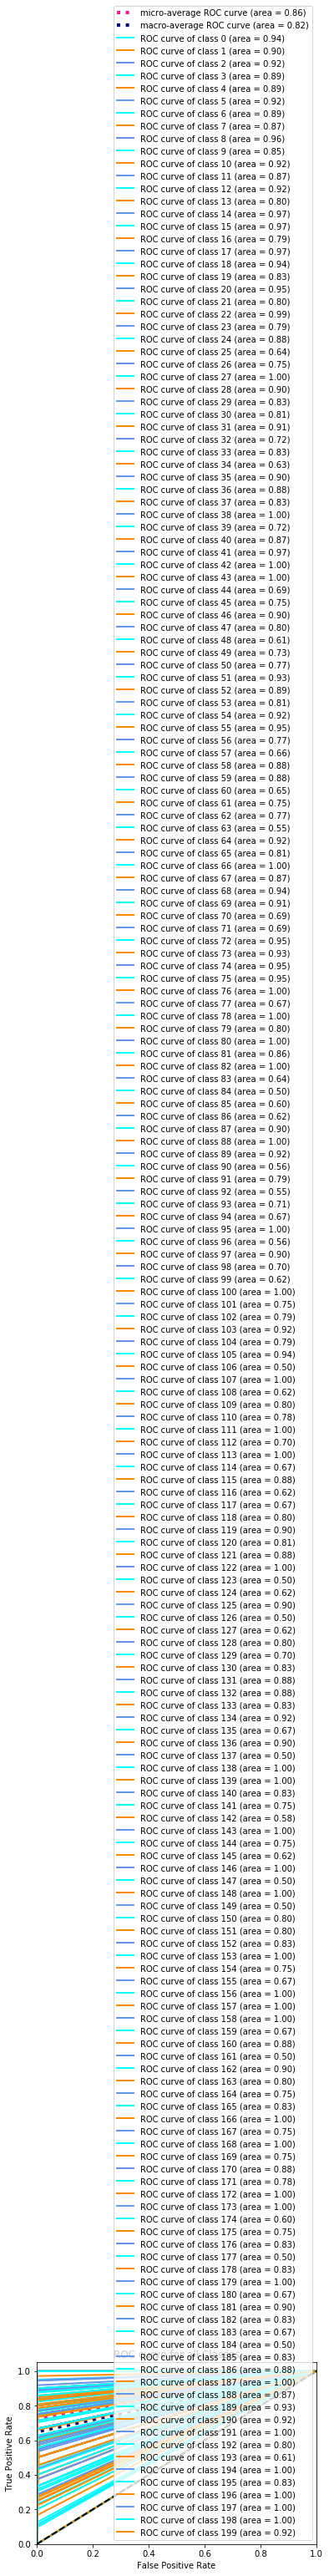

In [79]:
# So far, our best performing model has been BinaryRelevance with GradientBoostingClassifier as the base classifier 
# having an F1 Score of 0.831186703717  
# Here, I would be checking additional metrics on this model i.e. ROC Curve and AUC

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp


# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(df6_Label.columns)
y_score = predictions.toarray()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr = mean_tpr / n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)



plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for all Classes')
plt.legend(loc="lower right")
plt.show()

In [34]:
# Displaying the actual evaluation prediction result

def pred_result(df):
    lst1 = []
    lst2 = []
    for indx in list(range(len(df))):
        for col in df.columns:
            if df.iloc[indx,df.columns.get_loc(col)] == 1:
                lst1.append(col)
        lst2.append(', '.join(lst1))
        lst1 = []
    return lst2

df_Predict = pd.DataFrame(predictions.toarray(), columns=list(df6_Label.columns))
Tag_pred = pd.DataFrame(pred_result(df_Predict), columns=['Predicted_Tag'])
df_tag = pd.DataFrame(y_test, columns=list(df6_Label.columns))
Tag_true= pd.DataFrame(pred_result(df_tag), columns=['Tag'])
df_Eval = pd.merge(Tag_true, Tag_pred, left_index=True, right_index=True)
df_Eval.head(50)

,Tag,Predicted_Tag
0,git,git
1,,
2,graphics,graphics
3,android,android
4,"android, listview",android
5,,pdf
6,"php, image, codeigniter","php, codeigniter"
7,python,python
8,"c++, algorithm, homework","c++, algorithm, homework"
9,"windows, windows-7","windows, windows-7"


In [35]:
# Now, that we have chosen the best model. Next step is to predict on the Test data

#Preparing TestData
from pyspark.ml.feature import StopWordsRemover
test_df = test.drop("_id")
test_df = test_df.toPandas()
test_df['Body'] = test_df['Body'].apply(makeWordList)
test_df['Title'] = test_df['Title'].apply(makeWordList)
test_df['combined'] = test_df['Body'] + test_df['Title']
test_df['combined'] = test_df['combined'].apply(remDuplicate)

# Remove Stop words
test_df2 = sqlContext.createDataFrame(test_df)
remover = StopWordsRemover(inputCol="combined", outputCol="Filtered")
test_df3= remover.transform(test_df2)
test_df3.show()


+--------------------+-------+--------------------+--------------------+--------------------+
|                Body|     Id|               Title|            combined|            Filtered|
+--------------------+-------+--------------------+--------------------+--------------------+
|[how, do, i, disa...|6034196|[getting, rid, of...|[and, this, ltc-h...|[ltc-hgt, already...|
|[a, gateway-to-ga...|6034197|[node, inside, ci...|[and, this, all, ...|[sshes, cisco, fi...|
|[after, changing,...|6034198|[remove, old, vce...|[vsphere, old, ip...|[vsphere, old, ip...|
|[i, have, a, vari...|6034199|[replace, element...|[and, origin, lif...|[origin, lifted, ...|
|[today, i, purcha...|6034200|[will, php, inclu...|[text, file, cut,...|[text, file, cut,...|
|[with, the, follo...|6034201|[where, is, the, ...|[and, this, code,...|[code, manually, ...|
|[i, am, looking, ...|6034202|[iterating, over,...|[and, represent, ...|[represent, docum...|
|[importing, class...|6034203|[url, rewriting, ...|[code, hi

In [36]:
# Create the Feature Matrix for the test Data

test_df4 = test_df3.toPandas()
wordList_test = test_df4['Filtered'].tolist()
all_words_test = [j for i in wordList_test for j in i] 
all_words_test = list(set(all_words_test))

df5_test = pd.DataFrame(0, index=np.arange(len(wordList_test)), columns= df5.columns) 
indx = 0
for indx in list(range(len(wordList_test))):
    for col in df5_test.columns:
        if col in wordList_test[indx]:
            df5_test.iloc[indx,df5_test.columns.get_loc(col)] = 1                          
df5_test.head(10)

,c#,java,php,using,javascript,android,jquery,file,asp.net,sql,...,file-upload,contact,generating,parameters,equal,sent,android-ndk,align,username,exists
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
# predict
X_test = df5_test.as_matrix()
predictions = classifier.predict(X_test)

In [43]:
# Display Prediction result
df_Test = test.drop("_id").toPandas()
df_Predict = pd.DataFrame(predictions.toarray(), columns=list(df6_Label.columns))
Tag_pred = pd.DataFrame(pred_result(df_Predict), columns=['Predicted_Tag'])
df_Eval = pd.merge(df_Test, Tag_pred, left_index=True, right_index=True)
df_Eval.head(50)

,Body,Id,Title,Predicted_Tag
0,<p>How do I disable site-specific hotkeys if (...,6034196,Getting rid of site-specific hotkeys,"javascript, linux"
1,<p>I've a gateway-to-gateway VPN setup between...,6034197,Nodes inside Cisco VPN. Incoming SSH requests ...,"mysql, ssh"
2,<p>After changing our vCenter servers recently...,6034198,Remove old vCenter servers from VMWare vSphere...,
3,"<p>I have a variable i lifted the contents of,...",6034199,Replace <span> element with var containing html,jquery
4,<p>Today i purchase a small CMS system. With t...,6034200,Will PHP included html content affect my seo?,php
5,<p>With the following code Visual Studio + Res...,6034201,Where is the acronym menu in Visual Studio 2010?,
6,<p>I am looking for way to iterate over the re...,6034202,Iterating over the registers of a Yardoc `@macro`,"c, class"
7,<p>I'm importing classic ASP pages into a new ...,6034203,URL Rewriting from Winforms or console applica...,"winforms, file, application"
8,<p>How can I alphabetise (by title) my WordPre...,6034219,Alphabetised WordPress Posts,wordpress
9,<p>I am working on an ASP.Net application that...,6034204,Create Non-Culture Based ResourceManager for A...,"asp.net, file"
